In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import sys
#sys.path.append('/home/jma819/post_cmfe_analysis')
sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf
import scipy.spatial.distance as dist
import scipy.special as scipysp
import itertools
import math
import warnings
import numbers
from multiprocessing import Pool
from functools import partial
warnings.filterwarnings(action='once')

/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of 

In [2]:
reload(utils_jjm)
reload(dlc_utils)

<module 'dlc_utils' from '/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/dlc_utils.py'>

In [3]:
cnmfe_file_key = pd.read_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/cnmfe_file_key.csv')
#cnmfe_file_key = pd.read_csv('/projects/p30771/dlc_analysis/openfield_dlc_output/cnmfe_file_key.csv')

In [4]:
cnmfe_base_dir = '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/'
jaccard_data_directory = '/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/D1_mGluRKO_clustering/data/ko'
#cnmfe_base_dir = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/'
wt_CNMFE_files = ['30-Mar_20_39_05_out.mat', '30-Mar_20_45_16_out.mat', '27-Feb_17_33_59_out.mat', '22-Mar_22_52_02_out.mat',
                 '28-Feb_16_10_05_out.mat', '27-Feb_17_32_15_out.mat', '28-Feb_16_21_21_out.mat', '25-Mar_13_27_27_out.mat',
                 '25-Mar_14_22_02_out.mat', '25-Mar_14_22_44_out.mat', '26-Mar_18_33_55_out.mat', '27-Mar_00_26_12_out.mat', '27-Mar_00_48_46_out.mat']

ko_CNMFE_files = ['31-Mar_13_28_15_out.mat', '29-Mar_21_42_20_out.mat', '13-Apr_17_57_40_out.mat', '29-Mar_14_27_55_out.mat', '13-Apr_16_01_20_out.mat',
                 '13-Apr_16_11_27_out.mat', '29-Mar_13_39_44_out.mat']

In [5]:
tracking_files = ['/Volumes/My_Passport/dlc_analysis/behavcamvideos/open_field_miniscope/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in ko_CNMFE_files] 
#tracking_files = ['/projects/p30771/dlc_analysis/openfield_dlc_output/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 

In [6]:
CNMFE_dir_paths_list = [str(cnmfe_base_dir+fname) for fname in ko_CNMFE_files]
#CNMFE_dir_paths_list

In [7]:
binning_time = 1 # seconds 
body_part_for_tracking = 'tail_base' #
number_of_bins = 50 #
polynomial_degree = 2 #

grouped_raw_data = {}
success = []
failed = []
for CNMFE_file, tracking_file in zip(CNMFE_dir_paths_list, tracking_files):
    #print(CNMFE_file)
    #print(tracking_file)
    try:
        # load cell fluorescence 
        cell_fluorescence = sio.loadmat(CNMFE_file)
        C_timedelta = utils_jjm.create_fluorescence_time_delta(cell_fluorescence['C'])
        C_normalized = C_timedelta.apply(utils_jjm.normalize).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_z_scored = C_timedelta.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_normalized_z_scored = C_normalized.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_normalized)-1)*(1/20), len(C_normalized)), unit='s'), drop=True)
        # create tracking time deltas
        interpolated = utils_jjm.prepare_timedelta_dfs(tracking_file)
        #load spatial components by session
        com_df, spatial_components = utils_jjm.return_spatial_info(CNMFE_file, 0.6)
        cell_contours, for_dims = utils_jjm.create_contour_layouts(spatial_components)
        #C_z_scored_filtered = utils_jjm.filter_out_by_size(C_z_scored, cell_contours, for_dims, 0.6, 100)
        #store results 
        grouped_raw_data[tracking_file.split('/')[-2]] = {'C': C_timedelta, 'C_z_scored': C_z_scored, 'C_normalized': C_normalized, 'C_normalized_z_scored': C_normalized_z_scored, 
                                                          'interpolated' : interpolated, 'com' : com_df, 'spatial_components' : spatial_components, 'cell_contours': cell_contours,  
                                                         'for_dims' : for_dims}
        success.append((tracking_file.split('/')[-2], CNMFE_file.split('/')[-1]))
    except FileNotFoundError:
        failed.append(tracking_file)
    except OSError:
        failed.append(tracking_file)

In [8]:
CNMFE_dir_paths_list

['/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/31-Mar_13_28_15_out.mat',
 '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/29-Mar_21_42_20_out.mat',
 '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/13-Apr_17_57_40_out.mat',
 '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/29-Mar_14_27_55_out.mat',
 '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/13-Apr_16_01_20_out.mat',
 '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/13-Apr_16_11_27_out.mat',
 '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/29-Mar_13_39_44_out.mat']

In [11]:
#cnmfe results from matlab 
results = sio.loadmat(CNMFE_dir_paths_list[1])

In [12]:
# A is spatial traces of neurons
# C is spatial traces of neurons
# transform A to dense matrix 
dense_A = results['A'].todense()

In [13]:
# dimensions of final image
d1, d2 = 480, 752

In [14]:
# dimensions of C are neurons by frames
frames = np.shape(results['C'])[1]
cells = np.shape(results['C'])[0]

In [15]:
## should be able to pick out regions with high coacitivty by summing binned data, frames with highest have most active cells 

In [16]:
##get binned fluorescence and calc Jaccard scores
#arguments are sample widths to bin and z score threshold
#filter out very small cells
cells_in_session = grouped_raw_data['GRIN018_H17_M41_S43']['C_normalized_z_scored'].drop('msCamFrame', axis=1)
binned_fluorescence = cells_in_session.apply(utils_jjm.binning_function_uncrop, args=[1, 2])
binned_fluorescence_1S = cells_in_session.apply(utils_jjm.binning_function_uncrop, args=[10, 2])

In [17]:
# find frame regions with large numbers of active cells
sum_bins = binned_fluorescence.sum(axis=1)
sum_bins_1S = binned_fluorescence_1S.sum(axis=1)

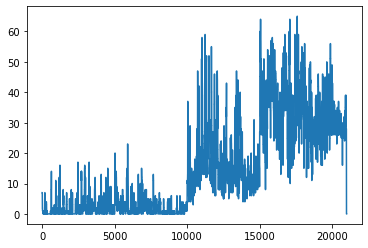

In [18]:
plt.plot(sum_bins_1S.values)

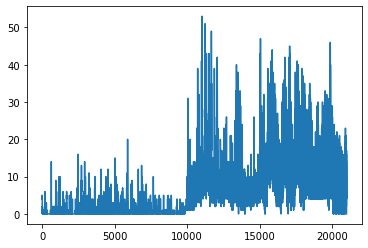

In [19]:
plt.plot(sum_bins.values)

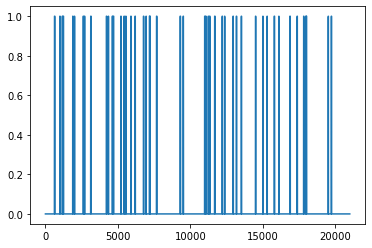

In [20]:
##get all peaks for a given cell, within 1 sec of threshold crossing and select an event at median intensity value 
plt.plot(binned_fluorescence_1S[2].values)
plt.show()

In [ ]:
#pick out subset of cells to view 
cells_to_view = [2]

In [21]:
#indices where signal intensity is above threshold
np.where(binned_fluorescence_1S[2].values == 1)[0]
#F/FO values at those indices
median_peak_intensity = cells_in_session[2].iloc[np.where(binned_fluorescence_1S[2].values == 1)[0]].median()
index = (np.abs(cells_in_session[2].values - median_peak_intensity)).argmin()

In [22]:
index

6194

In [32]:
# video of cell firing at median intensity
# reshape cells
frame_range = (index-40, index+40)
cells_reshaped = np.empty((len(cells_to_view), frame_range[1]-frame_range[0], d1, d2))
# reshape subset of cells
# need to iterate over number of cell in results['C'] dataset and index to store it in cells_reshaped video
for cell, cell_number  in tqdm(zip(cells_to_view, range(len(cells_to_view)))):
    A_reshaped = np.reshape(dense_A[:, cell], (d1, d2))
    cells_reshaped[cell_number] = np.array([np.dot(A_reshaped, results['C'][cell, frame]) for frame in range(frame_range[0], frame_range[1])])
    
#recombine cells 
#resulting array is frames, height, witdh
cells_recombined = np.sum(cells_reshaped, axis=0)

#display frames with all or subset of cells 
%matplotlib inline
fig = plt.figure()
im = plt.imshow(cells_recombined[0, :, :])
plt.close()
def init():
    im.set_data(cells_recombined[0, :, :])
def animate(i):
    im.set_data(cells_recombined[i, :, :])
    return(im)
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=cells_recombined.shape[0],
                               interval=50)
HTML(anim.to_html5_video())

1it [00:00,  2.14it/s]


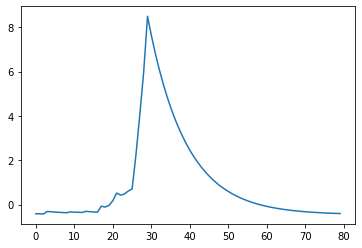

In [34]:
plt.plot(cells_in_session[cells_to_view].values[(index-40):(index+40)])

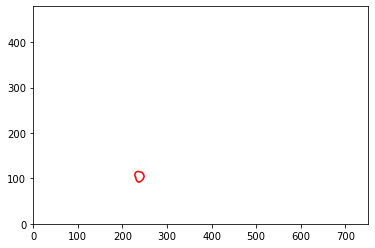

In [47]:
# plot contours of cells
# need to change this so 0 on y axis is at top left

# threshold for contour
maxthr=0.4
nrgthr=0.9

# mesh grid that represents the x, y dimensions of the image
x, y = np.mgrid[0:d1:1, 0:d2:1]

#cm is an array of tuples 
cm = utils_jjm.com(dense_A, d1, d2)
cells_to_plot = cells_to_view

for i in cells_to_plot:
    #pars = dict(kwargs)
    Bvec = dense_A[:, i].flatten()
    #normalize spatial contours to 1 
    Bvec /= np.max(Bvec)
    thr = maxthr
# reshape to dimensions of image 
    Bmat = np.reshape(Bvec, (d1, d2), order='C')
    colors = 'r'
    cs = plt.contour(y, x, Bmat, [thr], colors=colors)

In [ ]:
# within a frame subset, determine particular cells that are active 
# list((binned_fluorescence.iloc[15000:15010].iloc[:] == 1).any().index[(binned_fluorescence.iloc[15000:15010].iloc[:] == 1).any()])

In [ ]:
# should filter out small cells here 

In [ ]:
np.array((binned_fluorescence.iloc[15000:15010].iloc[:] == 1).any().index[(binned_fluorescence.iloc[15000:15010].iloc[:] == 1).any()])

In [ ]:
A_reshaped = np.reshape(dense_A[:, 0], (d1, d2))

In [ ]:
np.shape(A_reshaped)

In [ ]:
np.dot(A_reshaped, [255, 128, 0, results['C'][1, 1]])

In [ ]:
len(cells_to_plot)

In [ ]:
# reshape cells
frame_range = (15000, 15010)
#cells_reshaped = np.empty((cells, frame_range[1]-frame_range[0], d1, d2))
cells_reshaped_color = np.empty((len(cells_to_plot), frame_range[1]-frame_range[0], d2, d1, 4))
# reshape subset of cells
for cell in tqdm(range(len(cells_to_plot))):
    A_reshaped = np.reshape(dense_A[:, cells_to_plot[cell]], (d1, d2))
    #cells_reshaped[cell] = np.array([np.dot(A_reshaped, results['C'][cell, frame]) for frame in range(frame_range[0], frame_range[1])])
    cell_frames = []
    for frame in range(frame_range[0], frame_range[1]):
        cell_frames.append(np.transpose(np.array([np.dot(A_reshaped, item) for item in [255, 128, 0, results['C'][cells_to_plot[cell], frame]]])))
    cells_reshaped_color[cell] = cell_frames
cells_recombined_color = np.sum(cells_reshaped_color, axis=0)

In [ ]:
#display frames with all or subset of cells 
%matplotlib inline
fig = plt.figure()
im = plt.imshow(cells_recombined_color[0, :, :])
plt.close()
def init():
    im.set_data(cells_recombined_color[0, :, :])
def animate(i):
    im.set_data(cells_recombined_color[i, :, :])
    return(im)
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=cells_recombined_color.shape[0],
                               interval=50)
HTML(anim.to_html5_video())

In [ ]:
jaccard_data = pd.read_csv(jaccard_data_directory+'/'+'GRIN018_H17_M41_S43'+'_CellJaccards.csv', header=None)

In [ ]:
jaccard_data

In [ ]:
scipysp.binom(62, 2)

In [ ]:
frames

In [ ]:
cells